# Guided Project: Clean And Analyze Employee Exit Surveys
# Data Cleaning and Preparation

## Introduction.

* This notebook contains *all data cleaning and preparation operations* in preparation for analysis of employee exit surveys from TAFE and DETE.
* The analysis and an overview of the project can be found in [Resignation Analysis.ipynb](file:///Resignation%20Analysis.ipynb).

In this project I'll try to answer the following questions:

* Are employees who only worked for the institutes for a short period of time resigning due to some kind of job dissatisfaction? What about employees who have been there longer?
* Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

I'll be basing the analysis on exit surveys from Department of Education, Training and Employment (DETE) and the Technical and Further Education (TAFE) institute in Queensland, Australia.

We don't have a complete data dictionary for the datasets, so we'll have to rely on some general knowledge and interpretation of column names and values.

Below is a preview of a couple of relevant columns we'll work with from the `dete_survey.csv`:

* `ID`: An id used to identify the participant of the survey
* `SeparationType`: The reason why the person's employment ended
* `Cease Date`: The year or month the person's employment ended
* `DETE Start Date`: The year the person began employment with the DETE

Below is a preview of a couple of relevant columns we'll work with from the `tafe_survey.csv`:

* `Record ID`: An id used to identify the participant of the survey
* `Reason for ceasing employment`: The reason why the person's employment ended
* `LengthofServiceOverall. Overall Length of Service at Institute (in years)`: The length of the person's employment (in years)

This notebook stores prepared data for analysis as pickled dataframes.

* `combined_updated.pickle` contains a subset of the exit survey data.
  * Rows for resignations only
  * Only a subset of columns.
  * Cleaned key columns
  * Filled in missing employment duration by deriving it from existing columns
  * Categorized employment duration.
  * Created a column summarizing job dissatisfaction.


## Import Libraries and Configure Notebook Environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Read in Data

In [2]:
dete_survey = pd.read_csv('dete_survey.csv')
tafe_survey = pd.read_csv('tafe_survey.csv')

## DETE Survey Initial Overview

In [3]:
dete_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   ID                                   822 non-null    int64 
 1   SeparationType                       822 non-null    object
 2   Cease Date                           822 non-null    object
 3   DETE Start Date                      822 non-null    object
 4   Role Start Date                      822 non-null    object
 5   Position                             817 non-null    object
 6   Classification                       455 non-null    object
 7   Region                               822 non-null    object
 8   Business Unit                        126 non-null    object
 9   Employment Status                    817 non-null    object
 10  Career move to public sector         822 non-null    bool  
 11  Career move to private sector        822 non-

In [4]:
dete_survey.head()

,ID,SeparationType,Cease Date,DETE Start Date,Role Start Date,Position,Classification,Region,Business Unit,Employment Status,...,Kept informed,Wellness programs,Health & Safety,Gender,Age,Aboriginal,Torres Strait,South Sea,Disability,NESB
0,1,Ill Health Retirement,08/2012,1984,2004,Public Servant,A01-A04,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,Yes
1,2,Voluntary Early Retirement (VER),08/2012,Not Stated,Not Stated,Public Servant,AO5-AO7,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,NaN
2,3,Voluntary Early Retirement (VER),05/2012,2011,2011,Schools Officer,NaN,Central Office,Education Queensland,Permanent Full-time,...,N,N,N,Male,61 or older,NaN,NaN,NaN,NaN,NaN
3,4,Resignation-Other reasons,05/2012,2005,2006,Teacher,Primary,Central Queensland,NaN,Permanent Full-time,...,A,N,A,Female,36-40,NaN,NaN,NaN,NaN,NaN
4,5,Age Retirement,05/2012,1970,1989,Head of Curriculum/Head of Special Education,NaN,South East,NaN,Permanent Full-time,...,N,A,M,Female,61 or older,NaN,NaN,NaN,NaN,NaN


The DETE survey dataset contains 822 rows and 56 columns. They key columns of interest have been imported with no null values, but it is clear from a cursory glance at some of the rows that some of those columns have other values, like "Not Stated" for missing/unknown data. Many columns have a Dtype of 'object', some of which can be converted into boolean values. Many columns have null values. Most of those with null values are less than 25% null, but some have more, and some have a >75% of null values.

__Essential Columns:__

* `ID`: 0 missing values. int64. Values shouldn't need manipulation.
* `SeparationType`: 0 missing values. object. It appears these may be categorical values. It remains to be seen whether they are consistent, or need to be cleaned.
* `Cease Date`: 0 missing values. Object. Format appers to be MM/YYYY. 
* `DETE Start Date`: 0 missing values. Object. Format appears to be YYYY. Values include "Not Stated"

## TAFE Survey Initial Overview

In [5]:
tafe_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 72 columns):
 #   Column                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                         --------------  -----  
 0   Record ID                                                                                                                                                      702 non-null    float64
 1   Institute                                                                                                                                                      702 non-null    object 
 2   WorkArea                                                                                                                                  

In [6]:
tafe_survey.head()

,Record ID,Institute,WorkArea,CESSATION YEAR,Reason for ceasing employment,Contributing Factors. Career Move - Public Sector,Contributing Factors. Career Move - Private Sector,Contributing Factors. Career Move - Self-employment,Contributing Factors. Ill Health,Contributing Factors. Maternity/Family,...,Workplace. Topic:Does your workplace promote a work culture free from all forms of unlawful discrimination?,Workplace. Topic:Does your workplace promote and practice the principles of employment equity?,Workplace. Topic:Does your workplace value the diversity of its employees?,Workplace. Topic:Would you recommend the Institute as an employer to others?,Gender. What is your Gender?,CurrentAge. Current Age,Employment Type. Employment Type,Classification. Classification,LengthofServiceOverall. Overall Length of Service at Institute (in years),LengthofServiceCurrent. Length of Service at current workplace (in years)
0,6.341330e+17,Southern Queensland Institute of TAFE,Non-Delivery (corporate),2010.0,Contract Expired,NaN,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Female,26 30,Temporary Full-time,Administration (AO),1-2,1-2
1,6.341337e+17,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Retirement,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
2,6.341388e+17,Mount Isa Institute of TAFE,Delivery (teaching),2010.0,Retirement,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,6.341399e+17,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,6.341466e+17,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,Career Move - Private Sector,-,-,-,...,Yes,Yes,Yes,Yes,Male,41 45,Permanent Full-time,Teacher (including LVT),3-4,3-4


The TAFE survey dataset contains 702 rows and 72 columns. Key columns of interest have missing values. The `LengthofServiceOverall. Overall Length of Service at Institute (in years)` column has over 1/7th of the values missing. Non-null values in some columns include other values, like a dash, that seem to indicate missing information. Most columns have a dtype of 'object', many of which look like they can be converted into Boolean values. Some appear to contain a numeric range. Many column names are long and unweildy; they appear to include the full text of survey questions.

__Essential Columns:__

* `Record ID`: 0 missing values. Float64. Float64 is certainly not the best representation of this, but it may not matter for the purposes of our analysis.
* `Reason for ceasing employment`: 1 missing value. Object. Appears to be categorical. It is not clear whether the categories are represented consistently, or whether they'll need cleaning.
* `LengthofServiceOverall. Overall Length of Service at Institute (in years)`: 106 missing. Object. Appears to be categorical giving a rage of years.

It will take some work to merge these datasets for even the limited set of columns listed above.

## Manipulation / Cleaning

### Handling additional NaN values at import

In [7]:
dete_survey = pd.read_csv('dete_survey.csv', na_values=['Not Stated'])

### Drop unneeded columns

In [8]:
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis=1)
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis=1)

In [9]:
dete_survey_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   822 non-null    int64  
 1   SeparationType                       822 non-null    object 
 2   Cease Date                           788 non-null    object 
 3   DETE Start Date                      749 non-null    float64
 4   Role Start Date                      724 non-null    float64
 5   Position                             817 non-null    object 
 6   Classification                       455 non-null    object 
 7   Region                               717 non-null    object 
 8   Business Unit                        126 non-null    object 
 9   Employment Status                    817 non-null    object 
 10  Career move to public sector         822 non-null    bool   
 11  Career move to private sector   

In [10]:
tafe_survey_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 23 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Record ID                                                                  702 non-null    float64
 1   Institute                                                                  702 non-null    object 
 2   WorkArea                                                                   702 non-null    object 
 3   CESSATION YEAR                                                             695 non-null    float64
 4   Reason for ceasing employment                                              701 non-null    object 
 5   Contributing Factors. Career Move - Public Sector                          437 non-null    object 
 6   Contributing Factors. Career Move - Private Sector        

* Reimported `dete_survey.csv` so value "Not Stated" is recognized as NaN.  
* Dropped unneeded columns from both datasets.

### Clean and normalize column names

In [11]:
dete_survey_updated.columns = dete_survey_updated.columns.str.lower().str.strip().str.replace(' ', '_')
dete_survey_updated.columns

Index(['id', 'separationtype', 'cease_date', 'dete_start_date',
       'role_start_date', 'position', 'classification', 'region',
       'business_unit', 'employment_status', 'career_move_to_public_sector',
       'career_move_to_private_sector', 'interpersonal_conflicts',
       'job_dissatisfaction', 'dissatisfaction_with_the_department',
       'physical_work_environment', 'lack_of_recognition',
       'lack_of_job_security', 'work_location', 'employment_conditions',
       'maternity/family', 'relocation', 'study/travel', 'ill_health',
       'traumatic_incident', 'work_life_balance', 'workload',
       'none_of_the_above', 'gender', 'age', 'aboriginal', 'torres_strait',
       'south_sea', 'disability', 'nesb'],
      dtype='object')

In [12]:
dete_survey_updated.head()

,id,separationtype,cease_date,dete_start_date,role_start_date,position,classification,region,business_unit,employment_status,...,work_life_balance,workload,none_of_the_above,gender,age,aboriginal,torres_strait,south_sea,disability,nesb
0,1,Ill Health Retirement,08/2012,1984.0,2004.0,Public Servant,A01-A04,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,False,False,True,Male,56-60,NaN,NaN,NaN,NaN,Yes
1,2,Voluntary Early Retirement (VER),08/2012,NaN,NaN,Public Servant,AO5-AO7,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,False,False,False,Male,56-60,NaN,NaN,NaN,NaN,NaN
2,3,Voluntary Early Retirement (VER),05/2012,2011.0,2011.0,Schools Officer,NaN,Central Office,Education Queensland,Permanent Full-time,...,False,False,True,Male,61 or older,NaN,NaN,NaN,NaN,NaN
3,4,Resignation-Other reasons,05/2012,2005.0,2006.0,Teacher,Primary,Central Queensland,NaN,Permanent Full-time,...,False,False,False,Female,36-40,NaN,NaN,NaN,NaN,NaN
4,5,Age Retirement,05/2012,1970.0,1989.0,Head of Curriculum/Head of Special Education,NaN,South East,NaN,Permanent Full-time,...,True,False,False,Female,61 or older,NaN,NaN,NaN,NaN,NaN


In [13]:
tafe_column_map = {
    'Record ID': 'id',
    'CESSATION YEAR': 'cease_date',
    'Reason for ceasing employment': 'separationtype',
    'Gender. What is your Gender?': 'gender',
    'CurrentAge. Current Age': 'age',
    'Employment Type. Employment Type': 'employment_status',
    'Classification. Classification': 'position',
    'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service',
    'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'
}
tafe_survey_updated = tafe_survey_updated.rename(tafe_column_map, axis=1)
tafe_survey_updated.columns

Index(['id', 'Institute', 'WorkArea', 'cease_date', 'separationtype',
       'Contributing Factors. Career Move - Public Sector ',
       'Contributing Factors. Career Move - Private Sector ',
       'Contributing Factors. Career Move - Self-employment',
       'Contributing Factors. Ill Health',
       'Contributing Factors. Maternity/Family',
       'Contributing Factors. Dissatisfaction',
       'Contributing Factors. Job Dissatisfaction',
       'Contributing Factors. Interpersonal Conflict',
       'Contributing Factors. Study', 'Contributing Factors. Travel',
       'Contributing Factors. Other', 'Contributing Factors. NONE', 'gender',
       'age', 'employment_status', 'position', 'institute_service',
       'role_service'],
      dtype='object')

In [14]:
tafe_survey_updated.head()

,id,Institute,WorkArea,cease_date,separationtype,Contributing Factors. Career Move - Public Sector,Contributing Factors. Career Move - Private Sector,Contributing Factors. Career Move - Self-employment,Contributing Factors. Ill Health,Contributing Factors. Maternity/Family,...,Contributing Factors. Study,Contributing Factors. Travel,Contributing Factors. Other,Contributing Factors. NONE,gender,age,employment_status,position,institute_service,role_service
0,6.341330e+17,Southern Queensland Institute of TAFE,Non-Delivery (corporate),2010.0,Contract Expired,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Female,26 30,Temporary Full-time,Administration (AO),1-2,1-2
1,6.341337e+17,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Retirement,-,-,-,-,-,...,-,Travel,-,-,NaN,NaN,NaN,NaN,NaN,NaN
2,6.341388e+17,Mount Isa Institute of TAFE,Delivery (teaching),2010.0,Retirement,-,-,-,-,-,...,-,-,-,NONE,NaN,NaN,NaN,NaN,NaN,NaN
3,6.341399e+17,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,-,-,...,-,Travel,-,-,NaN,NaN,NaN,NaN,NaN,NaN
4,6.341466e+17,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,Career Move - Private Sector,-,-,-,...,-,-,-,-,Male,41 45,Permanent Full-time,Teacher (including LVT),3-4,3-4


* Standardized formatting of column names in the `dete_survey_updated` dataframes. 
* Renamed some column names in `tafe_survey_updated` dataframe to match. Untouched column names need additional work.

### Select only resignations

In [15]:
dete_survey_updated['separationtype'].value_counts()

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64

In [16]:
tafe_survey_updated['separationtype'].value_counts()

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64

In [17]:
dete_resignations = dete_survey_updated[dete_survey_updated['separationtype'].str.contains("Resignation")].copy()
tafe_resignations = tafe_survey_updated[tafe_survey_updated['separationtype'] == 'Resignation'].copy()

### Clean and normalize `cease_date` 

In [18]:
dete_resignations['cease_date'].value_counts()

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
07/2013      9
11/2013      9
10/2013      6
08/2013      4
05/2013      2
05/2012      2
09/2010      1
07/2012      1
2010         1
07/2006      1
Name: cease_date, dtype: int64

In [19]:
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.extract('/?(20[01][0-9])')[0].astype(float)

In [20]:
dete_resignations['cease_date'].value_counts().sort_index()

2006.0      1
2010.0      2
2012.0    129
2013.0    146
2014.0     22
Name: cease_date, dtype: int64

Extracted year and converted into a numeric value.

### Examine `dete_start_date`

In [21]:
dete_resignations['dete_start_date'].value_counts().sort_index()

1963.0     1
1971.0     1
1972.0     1
1973.0     1
1974.0     2
1975.0     1
1976.0     2
1977.0     1
1980.0     5
1982.0     1
1983.0     2
1984.0     1
1985.0     3
1986.0     3
1987.0     1
1988.0     4
1989.0     4
1990.0     5
1991.0     4
1992.0     6
1993.0     5
1994.0     6
1995.0     4
1996.0     6
1997.0     5
1998.0     6
1999.0     8
2000.0     9
2001.0     3
2002.0     6
2003.0     6
2004.0    14
2005.0    15
2006.0    13
2007.0    21
2008.0    22
2009.0    13
2010.0    17
2011.0    24
2012.0    21
2013.0    10
Name: dete_start_date, dtype: int64

In [22]:
dete_resignations['dete_start_date'].isnull().sum()

28

No cleaning appears necessary at this point.

### Check `cease_date` and `dete_start_date` for unusual values

In [23]:
dete_resignations['cease_date'].value_counts().sort_index()

2006.0      1
2010.0      2
2012.0    129
2013.0    146
2014.0     22
Name: cease_date, dtype: int64

cease_date            AxesSubplot(0.125,0.125;0.352273x0.755)
dete_start_date    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

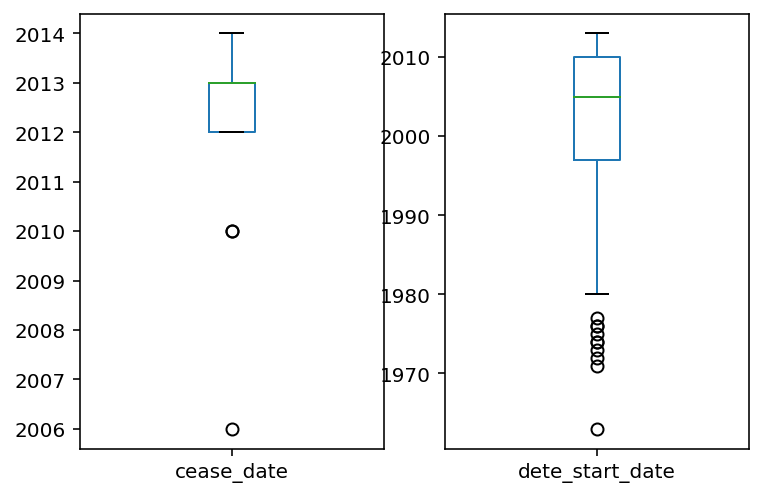

In [24]:
dete_resignations[['cease_date', 'dete_start_date']].plot.box(subplots=True)

In [25]:
tafe_resignations['cease_date'].value_counts().sort_index()

2009.0      2
2010.0     68
2011.0    116
2012.0     94
2013.0     55
Name: cease_date, dtype: int64

<AxesSubplot:>

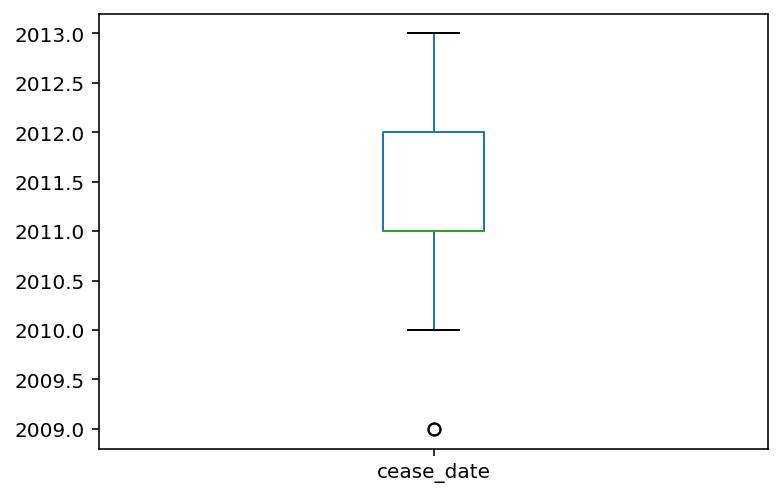

In [26]:
tafe_resignations['cease_date'].plot.box()

* The most recent resignations in the DETE dataset were in 2014, while the most recent start date is 2013. The earliest start dates among those who resigned from DETE is 1960. These are internally consitent. 
* Resignation dates in the TAFE dataset range from 2010 to 2013, with the majority in the 2011-2012 range.
* The earliest resignation in the DETE dataset was 2006, and the next two were in 2010. The bulk of resignations, over 250, occur in 2012 and 2013. I will examine this further in the analysis section.
* These facts are consistent with expectations, suggesting the datasets are in good condition for further analysis.

### Calculate `institute_service` duration for DETE data.

In [27]:
dete_resignations['institute_service'] = dete_resignations['cease_date'] - dete_resignations['dete_start_date']

In [28]:
dete_resignations['institute_service'].isnull().sum()

38

In [29]:
tafe_resignations['institute_service'].isnull().sum()

50

* Added a new column called `institute_service` to `dete_resignations`, in order compliment the column of the same name in tafe_resignations, and populated it with calculated values.
* I will use these values to categorize employees in my later analysis.

### Consolidate multiple columns into a summary `dissatisfied` column

In [30]:
tafe_dissatisfaction_columns = [
    'Contributing Factors. Dissatisfaction',
    'Contributing Factors. Job Dissatisfaction'
]
dete_dissatisfaction_columns = [
    'job_dissatisfaction',
    'dissatisfaction_with_the_department',
    'physical_work_environment',
    'lack_of_recognition',
    'lack_of_job_security',
    'work_location',
    'employment_conditions',
    'work_life_balance',
    'workload' 
]

In [31]:
tafe_resignations['Contributing Factors. Dissatisfaction'].value_counts()

-                                         277
Contributing Factors. Dissatisfaction      55
Name: Contributing Factors. Dissatisfaction, dtype: int64

In [32]:
tafe_resignations['Contributing Factors. Job Dissatisfaction'].value_counts()

-                      270
Job Dissatisfaction     62
Name: Contributing Factors. Job Dissatisfaction, dtype: int64

In [33]:
def update_vals(value):
    if pd.isnull(value):
        return np.nan
    elif value == '-':
        return False
    else:
        return True
tafe_resignations[tafe_dissatisfaction_columns] = tafe_resignations[tafe_dissatisfaction_columns].applymap(update_vals)

In [34]:
tafe_resignations['dissatisfied'] = tafe_resignations[tafe_dissatisfaction_columns].any(axis=1, skipna=False)
dete_resignations['dissatisfied'] = dete_resignations[dete_dissatisfaction_columns].any(axis=1, skipna=False)

* Identified columns in both data sets that indicate job dissatisfaction. 
* Verified that they didn't contain unexpected values.
* Cleaned relevant columns in `tafe_resignations` so values were represented as 'True' 'False' or 'NaN,' for consistency with `dete_resignations` dataset, and general best practices. 
* Created a summary column called `dissatisfied` in both datasets.

### Combine multiple columns into new `other_reason` column

In [35]:
dete_other_reason_columns = set(dete_resignations.columns[10:27]) - set(dete_dissatisfaction_columns)
dete_other_reason_columns

{'career_move_to_private_sector',
 'career_move_to_public_sector',
 'ill_health',
 'interpersonal_conflicts',
 'maternity/family',
 'relocation',
 'study/travel',
 'traumatic_incident'}

In [36]:
dete_resignations[dete_other_reason_columns]

,maternity/family,traumatic_incident,ill_health,career_move_to_public_sector,career_move_to_private_sector,interpersonal_conflicts,relocation,study/travel
3,False,False,False,False,True,False,False,False
5,True,False,False,False,True,False,False,False
8,False,False,False,False,True,False,False,False
9,False,False,False,False,False,True,False,False
11,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...
808,True,False,False,False,False,False,False,False
815,False,False,False,False,True,False,False,False
816,False,False,False,False,False,False,False,True
819,True,False,False,False,False,False,True,False


In [37]:
tafe_other_reason_columns = set(tafe_resignations.columns[5:16]) - set(tafe_dissatisfaction_columns)
tafe_other_reason_columns

{'Contributing Factors. Career Move - Private Sector ',
 'Contributing Factors. Career Move - Public Sector ',
 'Contributing Factors. Career Move - Self-employment',
 'Contributing Factors. Ill Health',
 'Contributing Factors. Interpersonal Conflict',
 'Contributing Factors. Maternity/Family',
 'Contributing Factors. Other',
 'Contributing Factors. Study',
 'Contributing Factors. Travel'}

In [38]:
tafe_resignations[list(tafe_other_reason_columns)] = tafe_resignations[tafe_other_reason_columns].applymap(update_vals)
tafe_resignations[tafe_other_reason_columns]

,Contributing Factors. Study,Contributing Factors. Career Move - Private Sector,Contributing Factors. Ill Health,Contributing Factors. Career Move - Self-employment,Contributing Factors. Other,Contributing Factors. Maternity/Family,Contributing Factors. Career Move - Public Sector,Contributing Factors. Interpersonal Conflict,Contributing Factors. Travel
3,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False
5,False,False,False,False,True,False,False,False,False
6,False,True,False,False,True,True,False,False,False
7,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
696,False,True,False,False,False,False,False,False,False
697,False,False,False,False,False,False,True,False,False
698,False,False,False,False,False,False,True,False,False
699,False,False,False,False,True,False,False,False,False


In [39]:
tafe_resignations['other_reasons'] = tafe_resignations[tafe_other_reason_columns].any(axis=1, skipna=False)
dete_resignations['other_reasons'] = dete_resignations[dete_other_reason_columns].any(axis=1, skipna=False)

In [40]:
tafe_resignations_up = tafe_resignations.copy()
dete_resignations_up = dete_resignations.copy()

### Combine DETE and TAFE datasets

In [41]:
dete_resignations_up['institute'] = "DETE"
tafe_resignations_up['institute'] = "TAFE"

In [42]:
combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index=True)

In [43]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 54 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   id                                                   651 non-null    float64
 1   separationtype                                       651 non-null    object 
 2   cease_date                                           635 non-null    float64
 3   dete_start_date                                      283 non-null    float64
 4   role_start_date                                      271 non-null    float64
 5   position                                             598 non-null    object 
 6   classification                                       161 non-null    object 
 7   region                                               265 non-null    object 
 8   business_unit                                        32 non-null     o

In [44]:
#If I don't make this a copy I get warning when I do an assignment below. I'm not sure why.
combined_updated = combined.dropna(thresh=500, axis=1).copy()
combined_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 651 non-null    float64
 1   separationtype     651 non-null    object 
 2   cease_date         635 non-null    float64
 3   position           598 non-null    object 
 4   employment_status  597 non-null    object 
 5   gender             592 non-null    object 
 6   age                596 non-null    object 
 7   institute_service  563 non-null    object 
 8   dissatisfied       643 non-null    object 
 9   other_reasons      643 non-null    object 
 10  institute          651 non-null    object 
dtypes: float64(2), object(9)
memory usage: 56.1+ KB


In preparation for combining both datasets into one, I created a column called `institute` in each dataset and populated it with an identifier. This will allow the origin of individual rows to be identified once the datasets are combined. The datasets were concatenated together. Afterwords, the number of null values in all columns was inspected. All necessary columns had at least 500 non-null values. Any other columns with less than 500 non-null values were dropped as they were not necessary or useful in completing our analysis.

### Categorization of service durration

The `institute_service` column currently contains a mishmash of categorical values and numeric values. I'm going to rework them into the following categories:

* New: Less than 3 years at a company
* Experienced: 3-6 years at a company
* Established: 7-10 years at a company
* Veteran: 11 or more years at a company

In [45]:
combined_updated['institute_service'].value_counts()

Less than 1 year      73
1-2                   64
3-4                   63
5-6                   33
11-20                 26
5.0                   23
1.0                   22
7-10                  21
3.0                   20
0.0                   20
6.0                   17
4.0                   16
9.0                   14
2.0                   14
7.0                   13
More than 20 years    10
13.0                   8
8.0                    8
20.0                   7
15.0                   7
14.0                   6
17.0                   6
12.0                   6
10.0                   6
22.0                   6
18.0                   5
16.0                   5
24.0                   4
23.0                   4
11.0                   4
39.0                   3
19.0                   3
21.0                   3
32.0                   3
36.0                   2
25.0                   2
26.0                   2
28.0                   2
30.0                   2
42.0                   1


The existing categorical values have different spans than the categories I plan to use, but fortunately, all of the existing spans fit within them. This means I can just concern myself with extracting the starting value.

In [46]:
combined_updated['institute_service'] = combined_updated['institute_service'].astype(str).str.extract('(\d+)').astype(float)

In [47]:
combined_updated['institute_service'].value_counts(dropna=False)

1.0     159
NaN      88
3.0      83
5.0      56
7.0      34
11.0     30
0.0      20
20.0     17
6.0      17
4.0      16
9.0      14
2.0      14
13.0      8
8.0       8
15.0      7
22.0      6
10.0      6
17.0      6
14.0      6
12.0      6
16.0      5
18.0      5
24.0      4
23.0      4
21.0      3
39.0      3
32.0      3
19.0      3
36.0      2
30.0      2
25.0      2
26.0      2
28.0      2
42.0      1
29.0      1
35.0      1
27.0      1
41.0      1
49.0      1
38.0      1
34.0      1
33.0      1
31.0      1
Name: institute_service, dtype: int64

In [48]:
def calc_service_cat(value):
    if pd.isnull(value):
        return np.NAN
    elif value < 3:
        return "New"
    elif 3 <= value < 7:
        return "Experienced"
    elif 7 <= value < 11:
        return "Established"
    elif 11 <= value:
        return "Veteran"
    else:
        return np.NAN    

In [49]:
combined_updated['service_cat'] = combined_updated['institute_service'].apply(calc_service_cat)

In [50]:
combined_updated['service_cat'].value_counts(dropna=False)

New            193
Experienced    172
Veteran        136
NaN             88
Established     62
Name: service_cat, dtype: int64

The `institute_service` column has been converted into consistent categories using the criteria described earlier.

### Handle missing values in `dissatisfied` and `other_reasons` column.

In [51]:
combined_updated['dissatisfied'].value_counts(dropna=False)

False    403
True     240
NaN        8
Name: dissatisfied, dtype: int64

In [52]:
#fill NaN with most common value (False)
combined_updated['dissatisfied'] = combined_updated['dissatisfied'].fillna(value=False).astype(bool)

In [53]:
combined_updated['other_reasons'].value_counts(dropna=False)

True     486
False    157
NaN        8
Name: other_reasons, dtype: int64

In [54]:
combined_updated['other_reasons'] = combined_updated['other_reasons'].fillna(value=False).astype(bool)

### Cleaning `age` values

In [55]:
combined_updated['age'].value_counts(dropna=False)

51-55            71
NaN              55
41-45            48
41  45           45
46-50            42
36-40            41
46  50           39
26-30            35
21  25           33
26  30           32
31  35           32
36  40           32
21-25            29
56 or older      29
31-35            29
56-60            26
61 or older      23
20 or younger    10
Name: age, dtype: int64

In [56]:
combined_updated['age'] = (combined_updated['age']
                            .str.strip()
                            .str.replace('  ', '-')
                            .str.replace('56-60', '56 or older')
                            .str.replace('61 or older', '56 or older')
                            )
combined_updated['age'].value_counts(dropna=False)

41-45            93
46-50            81
56 or older      78
36-40            73
51-55            71
26-30            67
21-25            62
31-35            61
NaN              55
20 or younger    10
Name: age, dtype: int64

### Explore null values in 'institute_service'

In [57]:
combined_updated.loc[combined_updated['institute_service'].isnull(),'institute'].value_counts()

TAFE    50
DETE    38
Name: institute, dtype: int64

In [58]:
combined_updated.pivot_table(index='institute', values='institute_service', aggfunc=['count'])

,count
,institute_service
institute,
DETE,273
TAFE,290


We are missing `institute_service` values for ~20% of resignations. Our analysis only looks at the subset where this column is populated, so filling this column or dropping rows is unnecessary.

### Store data for separate analysis

In [59]:
combined_updated.to_pickle('combined_updated.pickle')